In [15]:
import os, sys
from pathlib import Path

root_path = Path(os.getcwd()).parent.parent
sys.path.append(str(root_path) +'/')

morphomnist_path = root_path/'autoencoders'/'data'/'morphomnist'/'global'

In [16]:
from autoencoders.datasets import MorphomnistDataset
from torchvision import transforms 
from autoencoders.customTransforms import ToFloatMNIST

batch_size = 64
dataset = MorphomnistDataset(morphomnist_path, transforms.Compose([ToFloatMNIST(),transforms.ToTensor()]), gz=True)

In [3]:
import torchvision.transforms.functional as F

def show_np(imgs, features, labels,xlabel=True, title=None, n=None):
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):        
        axs[0, i].imshow(np.asarray(img), cmap='cividis') 
        xlabel= make_label(features[i], labels[i]) if xlabel else None
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=xlabel)
    plt.suptitle(title)   
    plt.close()
    return fig
    
def make_label(features, label):
    return f"Label: {label},  Thickness: {features[0]:.2f},\n Area: {features[1]:.2f}, Slant: {features[2]:.2f}"

In [4]:
def one_hot(a, veclen=10):
    b = torch.zeros((a.shape[0], veclen))
    b[torch.arange(a.shape[0]), a] = 1
    return b

def inverse_one_hot(b):
    return torch.argmax(b, axis=1)

In [5]:
import torch
from  torch.utils.data import DataLoader,random_split
import math
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from adversarial.automacaw import automacaw

In [6]:
m =len(dataset)
train_data, val_data = random_split(dataset, [math.floor(m-m*0.2), math.ceil(m*0.2)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

mse_train: 0.023, mse_val: 0.021, nll_train: -144.850, nll_val: -167.234
total_loss: 31.139, mse_val: 32.227, nll_val: -0.251


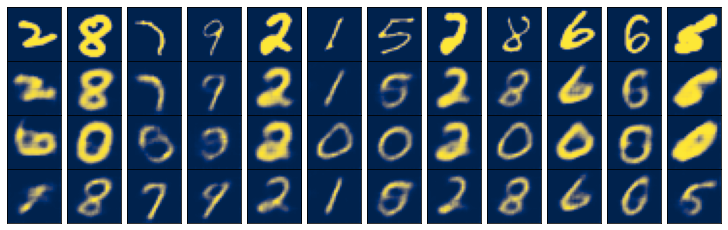

KeyboardInterrupt: 

In [20]:
encoded_dim = 128
macaw_dim = 128
automacaw_model = automacaw(encoded_dim, macaw_dim)
losses = {'total_loss':[], 'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

alpha = 0.0015
beta = 1500

for epoch in (pbar := tqdm(range(30))):
    nll_train_loss, mse_train_loss, total_loss = automacaw_model.train_everything(train_loader, alpha=alpha, beta=beta)
    losses['total_loss'].append(total_loss)
    losses['nll_train_loss'].append(nll_train_loss)
    losses['mse_train_loss'].append(mse_train_loss)    
    losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
    losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))
    
    clear_output()
    fig = automacaw_model.cf_test(val_loader,12)
    
    print(f"mse_train: {mse_train_loss:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}, nll_train: {nll_train_loss: .3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    print(f"total_loss: {total_loss:.3f}, mse_val: {losses['mse_val_loss'][-1] * beta:.3f}, nll_val: {losses['nll_val_loss'][-1] * alpha:.3f}")
    display(fig)

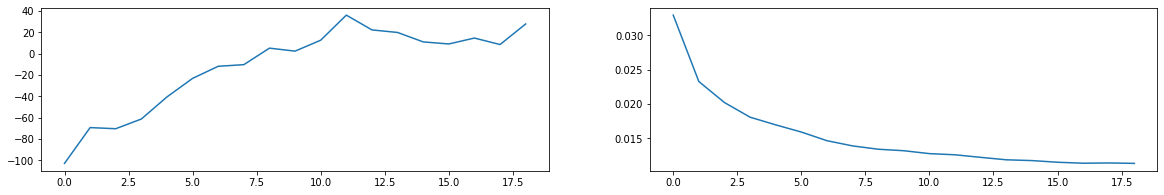

In [19]:
fig, axs = plt.subplots(1,2)
axs[0].plot(losses['nll_val_loss'])
axs[1].plot(losses['mse_val_loss'])

In [8]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)
encoded_dim = 64

separate_losses = {}
joined_losses = {}

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):   
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # train_dataset = torch.utils.data.Subset(dataset,train_ids)
    # val_dataset = torch.utils.data.Subset(dataset,test_ids)
       
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)  

    automacaw_model = automacaw(encoded_dim)
    losses = {'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}
  
    for epoch in (pbar := tqdm(range(60))):
        losses['mse_train_loss'].append(automacaw_model.train_encoder_decoder(train_loader))
        losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
        pbar.set_description(f"mse_train: {losses['mse_train_loss'][-1]:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}")
    
    for e in (pbar := tqdm(range(50))):
        losses['nll_train_loss'].append(automacaw_model.train_macaw(train_loader))
        losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))
        pbar.set_description(f"nll_train: {losses['nll_train_loss'][-1]:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    separate_losses[fold] = losses
    

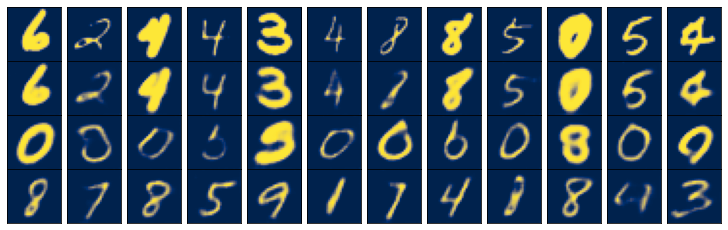

In [19]:
alpha = 0.0001
beta = 2200
losses = {'total_loss':[], 'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

automacaw_model = automacaw(encoded_dim)

for epoch in (pbar := tqdm(range(50))):

    nll_train_loss, mse_train_loss, total_loss = automacaw_model.train_everything(train_loader, alpha=alpha, beta=beta)
    losses['nll_train_loss'].append(nll_train_loss)
    losses['mse_train_loss'].append(mse_train_loss)    
    losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
    losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))

    clear_output()
    display(automacaw_model.cf_test(val_loader,12)) 

    pbar.set_description(f"total_loss: {total_loss:.3f}, mse_train: {mse_train_loss:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}, nll_train: {nll_train_loss: .3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
joined_losses[fold] = losses    

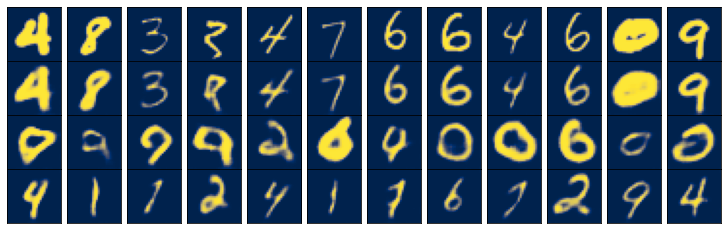

In [17]:
automacaw_model.cf_test(val_loader,12)


In [ ]:
import pickle
with open(macaw_path/'results'/'MIDL2024'/'MMNIST_losses.pkl', 'wb') as f:
    pickle.dump({'separate_losses':separate_losses, 'joined_losses':joined_losses}, f)

In [37]:
with open(macaw_path/'results'/'MIDL2024'/'MMNIST_losses.pkl', 'rb') as f:
    losses = pickle.load(f)

separate_losses = losses['separate_losses']
joined_losses = losses['joined_losses']

In [38]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5)

def mean_plot(d,key, fold=5):  
    losses = [d[i][key]for i in range(fold)]
    return np.mean(losses, axis=0), np.std(losses, axis=0)

sep_mse_mean, sep_mse_std = mean_plot(separate_losses,'mse_val_loss')
jon_mse_mean, jon_mse_std = mean_plot(joined_losses,'mse_val_loss')

sep_nll_mean, sep_nll_std = mean_plot(separate_losses,'nll_val_loss')
jon_nll_mean, jon_nll_std = mean_plot(joined_losses,'nll_val_loss')

[(-10000.0, -2000.0)]

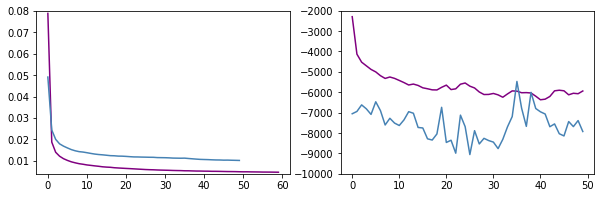

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,3)

fig, axs =  plt.subplots(1,2)

axs[0].plot(separate_losses[0]['mse_train_loss'], color='purple')
axs[0].plot(joined_losses[0]['mse_train_loss'], color='steelblue')
axs[0].set(ylim=[0.004,0.08])

# axs[0].fill_between(np.arange(60), sep_mse_mean - sep_mse_std/np.sqrt(5), sep_mse_mean + sep_mse_std/np.sqrt(5),
#                  color='purple', alpha=0.2)

# axs[0].fill_between(np.arange(60), jon_mse_mean[10:70] - jon_mse_std[10:70]/np.sqrt(5), jon_mse_mean[10:70] + jon_mse_std[10:70]/np.sqrt(5),
#                  color='steelblue', alpha=0.2)

axs[1].plot(separate_losses[0]['nll_train_loss'], color='purple')
axs[1].plot(joined_losses[0]['nll_train_loss'], color='steelblue')
axs[1].set(ylim = [-10000,-2000])

# axs[1].fill_between(np.arange(30), sep_nll_mean[:30] - sep_nll_std[:30]/np.sqrt(5), sep_nll_mean[:30] + sep_nll_std[:30]/np.sqrt(5),
#                  color='purple', alpha=0.2)

# axs[1].fill_between(np.arange(30), jon_nll_mean[70:100] - jon_nll_std[70:100]/np.sqrt(5), jon_nll_mean[70:100] + jon_nll_std[70:100]/np.sqrt(5),
#                  color='steelblue', alpha=0.2)

[(-2000.0, 2500.0)]

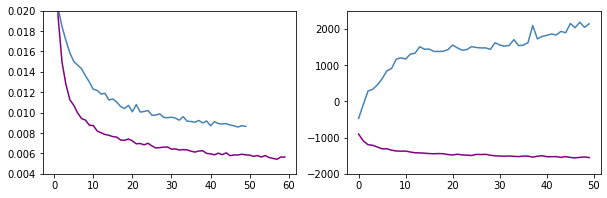

In [39]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,3)

fig, axs =  plt.subplots(1,2)

axs[0].plot(sep_mse_mean, color='purple')
axs[0].plot(jon_mse_mean, color='steelblue')
axs[0].set(ylim=[0.004,0.02])

# axs[0].fill_between(np.arange(60), sep_mse_mean - sep_mse_std/np.sqrt(5), sep_mse_mean + sep_mse_std/np.sqrt(5),
#                  color='purple', alpha=0.2)

# axs[0].fill_between(np.arange(60), jon_mse_mean[10:70] - jon_mse_std[10:70]/np.sqrt(5), jon_mse_mean[10:70] + jon_mse_std[10:70]/np.sqrt(5),
#                  color='steelblue', alpha=0.2)

axs[1].plot(sep_nll_mean, color='purple')
axs[1].plot(jon_nll_mean, color='steelblue')
axs[1].set(ylim = [-2000,2500])

# axs[1].fill_between(np.arange(30), sep_nll_mean[:30] - sep_nll_std[:30]/np.sqrt(5), sep_nll_mean[:30] + sep_nll_std[:30]/np.sqrt(5),
#                  color='purple', alpha=0.2)

# axs[1].fill_between(np.arange(30), jon_nll_mean[70:100] - jon_nll_std[70:100]/np.sqrt(5), jon_nll_mean[70:100] + jon_nll_std[70:100]/np.sqrt(5),
#                  color='steelblue', alpha=0.2)

## Pretrain MACAW

In [13]:
for e in (pbar := tqdm(range(80))):
    losses['nll_train_loss'].append(automacaw.train_macaw(train_loader))
    losses['nll_val_loss'].append(automacaw.test_likelihood(val_loader))
    losses['mse_val_loss'].append(automacaw.test_MSE(val_loader))
    pbar.set_description(f"nll_train: {losses['nll_train_loss'][-1]:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}")

display(automacaw.cf_test(val_loader,12))

import pickle
with open(macaw_path/'models'/'MIDL'/'macaw_pretrained.pkl', 'wb') as f:
    pickle.dump({'macaw':automacaw.macaw, 'feature_mean':automacaw.feature_mean, 'feature_std':automacaw.feature_std}, f)

In [122]:
test_ids

array([    2,    14,    25, ..., 59993, 59996, 59998])

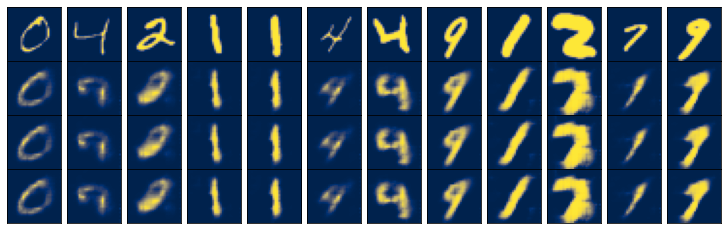

In [68]:
test_sample_size = 12
subset_dataset = torch.utils.data.Subset(dataset, test_ids[:test_sample_size])
test_sample_loader = torch.utils.data.DataLoader(subset_dataset,batch_size=test_sample_size)

display(automacaw_model.cf_test(test_sample_loader,12))


In [36]:
display(automacaw.cf_test(val_loader,12))

TypeError: unsupported operand type(s) for -: 'Tensor' and 'NoneType'

<Figure size 1440x216 with 0 Axes>

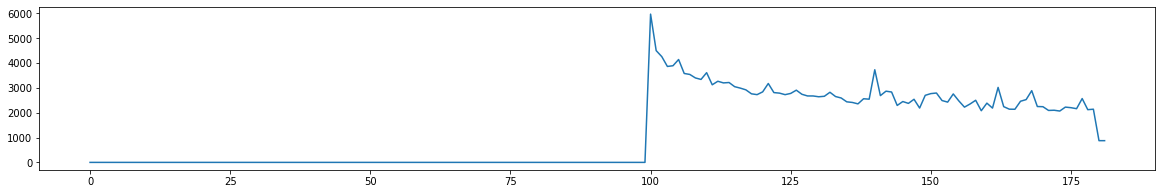

In [21]:
plt.plot(losses['nll_val_loss'])

## Pretraining together 

Selected device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

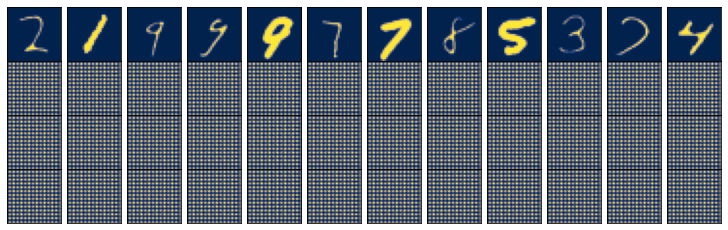

  0%|          | 0/60 [00:00<?, ?it/s]

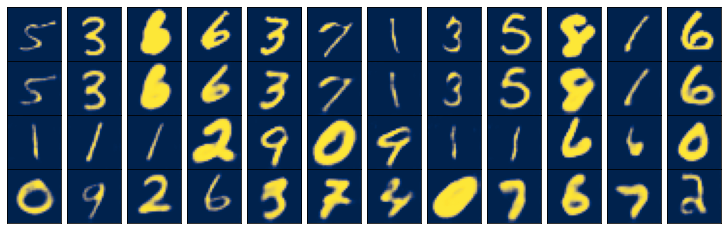

  0%|          | 0/50 [00:00<?, ?it/s]

In [132]:
automacaw_model = automacaw(encoded_dim)
losses = {'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

for e in (pbar := tqdm(range(10))):
    losses['nll_train_loss'].append(automacaw_model.train_encoder_macaw(train_loader))
    losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))
    losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
    pbar.set_description(f"nll_train: {losses['nll_train_loss'][-1]:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}")

# display(automacaw.plot_ae_outputs(val_loader))
display(automacaw_model.cf_test(val_loader,12))

for epoch in (pbar := tqdm(range(60))):
    losses['mse_train_loss'].append(automacaw_model.train_encoder_decoder(train_loader))
    losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
    losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))
    pbar.set_description(f"mse_train: {losses['mse_train_loss'][-1]:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    

# display(automacaw.plot_ae_outputs(val_loader))
display(automacaw_model.cf_test(val_loader,12))


for epoch in (pbar := tqdm(range(50))):
    losses['nll_train_loss'].append(automacaw_model.train_macaw(train_loader))
    losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
    losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))
    pbar.set_description(f"nll_train: {losses['nll_train_loss'][-1]:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    

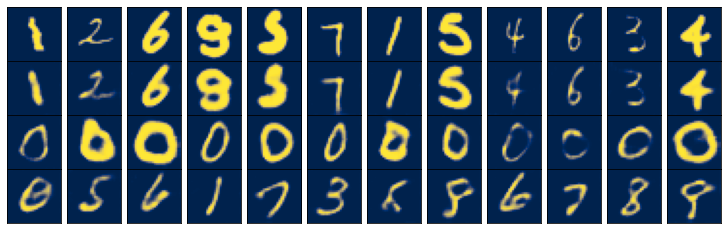

In [111]:
# display(automacaw.plot_ae_outputs(val_loader))
display(automacaw_model.cf_test(val_loader,12))

In [118]:
next(iter(val_loader))[1][:5]

tensor([[ 2.1954e+00,  8.5875e+01, -8.0480e-02],
        [ 6.8956e+00,  2.7556e+02,  1.1128e-01],
        [ 1.1852e+00,  3.2938e+01, -4.4389e-02],
        [ 6.2636e+00,  2.6125e+02,  1.2596e-01],
        [ 1.5194e+00,  6.4500e+01,  1.4839e-01]], dtype=torch.float64)

In [119]:
next(iter(val_loader))[1][:5]

tensor([[ 6.7719e+00,  1.9838e+02,  6.0818e-01],
        [ 6.4842e+00,  3.1831e+02, -5.3352e-02],
        [ 2.4176e+00,  9.2562e+01, -1.6923e-01],
        [ 2.6373e+00,  1.3644e+02,  2.1832e-01],
        [ 3.1186e+00,  1.1944e+02,  4.9006e-01]], dtype=torch.float64)

In [113]:
automacaw_model.test_likelihood(train_loader)

-3861.532510416667

(-5000.0, 0.0)

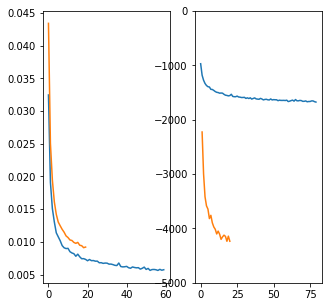

In [106]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5)

fig, axs =  plt.subplots(1,2)

axs[0].plot(sep_mse_mean)
axs[0].plot(jon_mse_mean[10:30])

axs[1].plot(sep_nll_mean)
axs[1].plot(jon_nll_mean[29:])
axs[1].set_ylim([-5000,0])

train loss: 0.040813613682985306
val loss: 0.03234138339757919


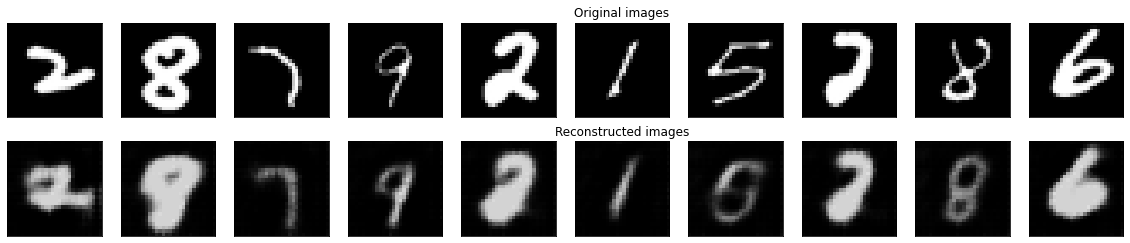

In [ ]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

losses = {'train_loss':[],'val_loss':[]}

for epoch in range(1):
    losses['train_loss'].append(automacaw.train_encoder_decoder(train_loader))
    losses['val_loss'].append(automacaw.test_MSE(val_loader))
    clear_output()
    print(f"train loss: {losses['train_loss'][-1]}")
    print(f"val loss: {losses['val_loss'][-1]}")
    display(automacaw.plot_ae_outputs(val_loader))
    

In [ ]:
plt.rcParams['figure.figsize'] = (20, 5)
losses = {'train_loss':[],'val_loss':[]}

for e in (range(10)):
    losses['train_loss'].append(automacaw.train_macaw(train_loader))
    losses['val_loss'].append(automacaw.test_likelihood(val_loader))
    
    print(f"train loss: {losses['train_loss'][-1]}")
    print(f"val loss: {losses['val_loss'][-1]}")

train loss: -1728.6028030853272
val loss: -2203.589559352144
train loss: -2929.4231829071045
val loss: -3518.0582587059507
train loss: -3225.8858661549884
val loss: -3760.172606123255
train loss: -3313.2769402414956
val loss: -3759.040316967254
train loss: -3438.819860285441
val loss: -4090.819395674036
train loss: -3553.245891845703
val loss: -4476.622476780668
train loss: -3500.908722768148
val loss: -4410.590250218168
train loss: -3651.5734968465167
val loss: -4401.982746530087
train loss: -3724.387690195719
val loss: -4232.789907901845
train loss: -3729.3166205749512
val loss: -4451.996772928441


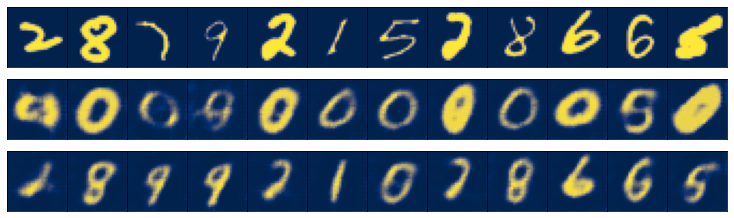

In [10]:
fig = automacaw.cf_test(val_loader,12)
display(fig)

train loss: 6437.149027119955
val loss: -1940.8106286880818
mse loss: 0.031752169132232666


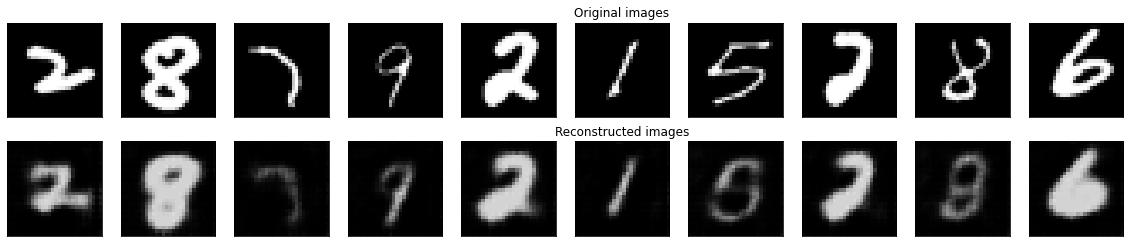

In [11]:
losses = {'train_loss':[],'val_loss':[], 'mse_loss':[]}

for epoch in range(10):
    losses['train_loss'].append(automacaw.train_encoder_with_likelihood(train_loader))
    losses['val_loss'].append(automacaw.test_likelihood(val_loader))
    losses['mse_loss'].append(automacaw.test_MSE(val_loader))
    
    clear_output()
    print(f"train loss: {losses['train_loss'][-1]}")
    print(f"val loss: {losses['val_loss'][-1]}")
    print(f"mse loss: {losses['mse_loss'][-1]}")
    
    display(automacaw.plot_ae_outputs(val_loader))

train loss: 0.0235684085637331
val loss: 0.02316879667341709
Nlikelihood loss: -1940.8106286880818


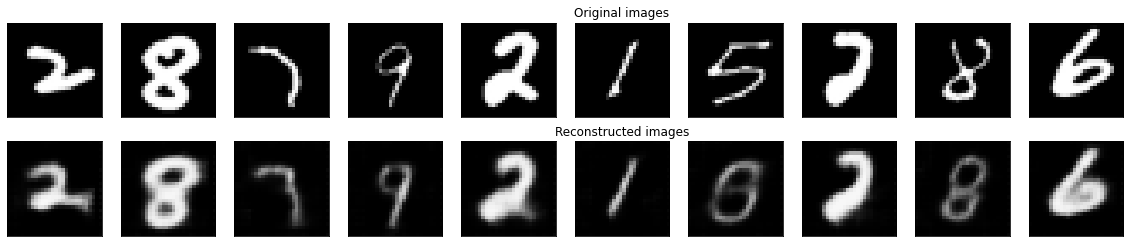

In [13]:
losses = {'train_loss':[],'val_loss':[], 'neg_likelihood':[]}

for epoch in range(10):
    losses['train_loss'].append(automacaw.train_decoder(train_loader))
    losses['val_loss'].append(automacaw.test_MSE(val_loader))
    losses['neg_likelihood'].append(automacaw.test_likelihood(val_loader))
    clear_output()
    print(f"train loss: {losses['train_loss'][-1]}")
    print(f"val loss: {losses['val_loss'][-1]}")
    print(f"Nlikelihood loss: {losses['neg_likelihood'][-1]}")
    
    display(automacaw.plot_ae_outputs(val_loader))

In [1]:
fig = automacaw.cf_test(val_loader,12)
display(fig)

NameError: name 'automacaw' is not defined